<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2*

# Sprint Challenge - Neural Network Foundations

Table of Problems

1. [Defining Neural Networks](#Q1)
2. [Chocolate Gummy Bears](#Q2)
    - Perceptron
    - Multilayer Perceptron
4. [Keras MMP](#Q3)

<a id="Q1"></a>
## 1. Define the following terms:

- **Neuron:**
-- a perceptron that takes a weighted sum of inputs, adds bias, as passes through an activation function to determine whether it passes info to the next stage; where output = activation_function(WX + b)
- **Input Layer:**
-- the layer that takes the input neurons/ brings the data into the system
- **Hidden Layer:**
-- the "black box" of the NN, in between the input and output layers, doesn't look outside
- **Output Layer:**
-- the final layer that outputs the numbers/makes inferences
- **Activation:**
-- transforms a matrix into a desirable shape for output. (sigmoid, tanh, step, relu)
- **Backpropagation:**
-- goal is to adjust each weight in the network proportional to how much it contributes to the overall error


## 2. Chocolate Gummy Bears <a id="Q2"></a>

Right now, you're probably thinking, "yuck, who the hell would eat that?". Great question. Your candy company wants to know too. And you thought I was kidding about the [Chocolate Gummy Bears](https://nuts.com/chocolatessweets/gummies/gummy-bears/milk-gummy-bears.html?utm_source=google&utm_medium=cpc&adpos=1o1&gclid=Cj0KCQjwrfvsBRD7ARIsAKuDvMOZrysDku3jGuWaDqf9TrV3x5JLXt1eqnVhN0KM6fMcbA1nod3h8AwaAvWwEALw_wcB). 

Let's assume that a candy company has gone out and collected information on the types of Halloween candy kids ate. Our candy company wants to predict the eating behavior of witches, warlocks, and ghosts -- aka costumed kids. They shared a sample dataset with us. Each row represents a piece of candy that a costumed child was presented with during "trick" or "treat". We know if the candy was `chocolate` (or not chocolate) or `gummy` (or not gummy). Your goal is to predict if the costumed kid `ate` the piece of candy. 

If both chocolate and gummy equal one, you've got a chocolate gummy bear on your hands!?!?!
![Chocolate Gummy Bear](https://ed910ae2d60f0d25bcb8-80550f96b5feb12604f4f720bfefb46d.ssl.cf1.rackcdn.com/3fb630c04435b7b5-2leZuM7_-zoom.jpg)

In [123]:
from google.colab import files
uploaded = files.upload()

Saving chocolate_gummy_bears.csv to chocolate_gummy_bears (2).csv


In [0]:
import pandas as pd
candy = pd.read_csv('chocolate_gummy_bears.csv')

In [64]:
print(candy.shape)
candy.head()

(10000, 3)


,chocolate,gummy,ate
0,0,1,1
1,1,0,1
2,0,1,1
3,0,0,0
4,1,1,0


### Perceptron

To make predictions on the `candy` dataframe. Build and train a Perceptron using numpy. Your target column is `ate` and your features: `chocolate` and `gummy`. Do not do any feature engineering. :P

Once you've trained your model, report your accuracy. Explain why you could not achieve a higher accuracy with a *simple perceptron*. It's possible to achieve ~95% accuracy on this dataset.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
np.random.seed(42)

In [66]:
# Start your candy perceptron here

# train, test split
X_train, X_test, y_train, y_test = train_test_split(candy.iloc[:, :-1].values, 
                                                    candy.iloc[:, -1].values, 
                                                    test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 2), (2000, 2), (8000,), (2000,))

In [0]:
class Perceptron():
    def __init__(self, inputs=2, output=1, rate=0.01, n_iter=1000):
        self.input = inputs
        self.output = output
        self.rate = rate
        self.n_iter = n_iter
        
        # Initialize random weights
        self.weight = np.random.randn(inputs, output)
        
        # Initialize bias
        self.bias = np.zeros(output)
        
        # Initialize loss function (empty list for empty perceptron)
        self.loss = []
        pass
    
    # Define sigmoid function
    def sigmoid(self, x):
        """
        Sigmoid function
        """
        return 1 / (1 + np.exp(-x))
    
    # Sigmoid derivative function
    def sigmoid_derivative(self, x):
        """
        Sigmoid derivative
        """
        sx = self.sigmoid(x)
        return sx * (1-sx)
    
    # Define neural network affine function
    def affine_func(self, x, w, b):
        '''
        y = Wx + b
        '''
        scores = x.dot(w) + b
        cache = (x, w, b)
        return scores, cache
    
    # Define back-propagation
    def back_prop(self, d_out, cache):
        '''
        dY
        '''
        x, w, b = cache
        dx = d_out.dot(w.T)
        dw = x.reshape(-1, 1).dot(d_out.reshape(-1, 1))
        db = np.sum(d_out, axis=0)
        
        return dx, dw, db
    
    def fit(self, x, y):
        '''
        Fit the perceptron
        '''
        for i in range(self.n_iter):            
            for j in range(x.shape[0]):
                # forward prop
                scores, cache = self.affine_func(x[j], self.weight, self.bias)
                
                # scoring
                out = self.sigmoid(scores)
                loss = y[j] - out.reshape(-1,)
                self.loss.append(loss)
                
                # back prop
                dout = loss * self.sigmoid_derivative(out)
                _, dw, db = self.back_prop(dout.reshape(-1,), cache)
        
                # gradient update
                self.weight += dw
                self.bias += db
        pass
        
    def predict(self, x):
        '''
        Make predictions
        '''
        return self.sigmoid(self.affine_func(x, self.weight, self.bias)[0])

In [0]:
choco_gum = Perceptron(inputs=2, output=1)
choco_gum.fit(X_train, y_train)

In [69]:
y_pred = choco_gum.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f'accuracy is {accuracy_score(y_test, y_pred.reshape(-1,))}')

accuracy is 0.7295


In [11]:
'''
There is only so much we can do with a simple perceptron because of it's
simplicity. There are no hidden layers to help identify different patterns
within the dataset
'''

"\nThere is only so much we can do with a simple perceptron because of it's\nsimplicity. There are no hidden layers to help identify different patterns\nwithin the dataset\n"

### Multilayer Perceptron <a id="Q3"></a>

Using the sample candy dataset, implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. Your Multilayer Perceptron should be implemented in Numpy. 
Your network must have one hidden layer.

Once you've trained your model, report your accuracy. Explain why your MLP's performance is considerably better than your simple perceptron's on the candy dataset. 

In [0]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [0]:
from scipy import optimize


class Neural_Network:
    def __init__(self, inputLayerSize=3, hiddenLayerSize=4, outputLayerSize=1, seed=42):
        """
        Initialize Single Hidden Layer Neural Network with input size, hidden layer size, output layer size, learning rate, momemtum, iterations, and random seed
        """       
        # Setup architecture of neural network
        self.inputLayerSize = inputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.outputLayerSize = outputLayerSize
        
        # Set random seed fixed
        self.__set_seed(seed=seed)

        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
  
    def __set_seed(self, seed):
        np.random.seed(seed)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        delta2 = np.dot(delta3, self.W2.T) * self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

    def predict(self, X, threshold=0.5):
        y_preds = nn.forward(X)
        return (y_preds > threshold).astype('int32')

class Optimizer:
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [72]:
nn = Neural_Network(inputLayerSize=2, hiddenLayerSize=4, outputLayerSize=1, seed=42)
opt = Optimizer(nn)

opt.train(X_train, y_train)
y_preds = nn.forward(X_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


         Current function value: 318.444613
         Iterations: 17
         Function evaluations: 78
         Gradient evaluations: 66


In [73]:
print(f"Loss: {np.mean(np.square(y_train - y_preds))}") 

Loss: 0.07961115330340161


In [74]:
y_preds = nn.forward(X_test)
y_preds = (y_preds > .5).astype(int)
accuracy_score(y_test, y_preds)

0.946

In [0]:
'''
Multilayer are able to identify non-linear relationships, and hidden patterns
in the data, which makes them much more durable than a singular perceptron.
'''

'\nMultilayer are able to identify non-linear relationships, which makes them\nmuch more durable than a singular perceptron.\n'

P.S. Don't try candy gummy bears. They're disgusting. 

## 3. Keras MMP <a id="Q3"></a>

Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy.
Use the Heart Disease Dataset (binary classification)
Use an appropriate loss function for a binary classification task
Use an appropriate activation function on the final layer of your network.
Train your model using verbose output for ease of grading.
Use GridSearchCV or RandomSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
When hyperparameter tuning, show you work by adding code cells for each new experiment.
Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
You must hyperparameter tune at least 3 parameters in order to get a 3 on this section.

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv')
df = df.sample(frac=1)
print(df.shape)
df.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
253,67,1,0,100,299,0,0,125,1,0.9,1,2,2,0
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
39,65,0,2,160,360,0,0,151,0,0.8,2,0,2,1
197,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0


In [0]:
X = df.drop(columns='target')
y = df['target']

sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227, 13), (76, 13), (227,), (76,))

In [17]:
from tensorflow.keras.layers import BatchNormalization

# Instantiate the model
model = Sequential()

# Add layers to the model (1 hidden layer as base model)

# Input -> Hidden
model.add(Dense(64, input_dim=13, activation='relu'))
model.add(BatchNormalization())

# Hidden
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

# Hidden -> Output
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit model
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=100, batch_size=50)

# Inspect architecture
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 181 samples, validate on 46 samples
Epoch 1/100
181/181 [==============================] - 1s 3ms/sample - loss: 0.6247 - acc: 0.6464 - val_loss: 0.6143 - val_acc: 0.6087
Epoch 2/100
181/181 [==============================] - 0s 92us/sample - loss: 0.4786 - acc: 0.7735 - val_loss: 0.5772 - val_acc: 0.7174
Epoch 3/100
181/181 [==============================] - 0s 67us/sample - loss: 0.4047 - acc: 0.7735 - val_loss: 0.5454 - val_acc: 0.7391
Epoch 4/100
181/181 [==============================] - 0s 78us/sample - loss: 0.3471 - acc: 0.8398 - val_loss: 0.5212 - val_acc: 0.7609
Epoch 5/100
181/181 [==============================] - 0s 94us/sample - loss: 0.3154 - acc: 0.8674 - val_loss: 0.5025 - val_acc: 0.7826
Epoch 6/100
181/181 [==============================] - 0s 81us/sample - loss: 0.2910 - acc: 0.8785 - 

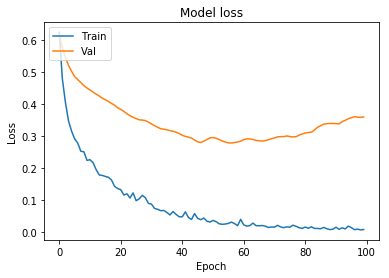

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

In [19]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy is {scores[1]}")

Test accuracy is 0.7105262875556946


In [20]:
# GridSearch for accuracy
inputs = X_train.shape[1]

def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(inputs,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'batch_size': [16, 32, 64],
              'epochs': [20, 80]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.8590308427810669 using {'batch_size': 16, 'epochs': 20}
Means: 0.8590308427810669, Stdev: 0.02185862701482951 with: {'batch_size': 16, 'epochs': 20}
Means: 0.806167393266367, Stdev: 0.006910155139040082 with: {'batch_size': 16, 'epochs': 80}
Means: 0.8458149890017405, Stdev: 0.005281195485131463 with: {'batch_size': 32, 'epochs': 20}
Means: 0.8237885341770323, Stdev: 0.030119293470170134 with: {'batch_size': 32, 'epochs': 80}
Means: 0.841409692155107, Stdev: 0.01774149856074191 with: {'batch_size': 64, 'epochs': 20}
Means: 0.8061673985178776, Stdev: 0.021637560564110855 with: {'batch_size': 64, 'epochs': 80}


In [21]:
print(f'{grid_result.best_params_} {grid_result.best_score_}')

{'batch_size': 16, 'epochs': 20} 0.8590308427810669


In [23]:
g_pred = grid.predict(X_test)
accuracy_score(y_test, g_pred)

0.7894736842105263